## set running directory

In [1]:
from __future__ import print_function
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir


DATA_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "data")
try_mkdir(DATA_PATH)
MODEL_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "model")
try_mkdir(MODEL_PATH)

GF_DATA_PATH = os.path.join(DATA_PATH, "gf3d")
try_mkdir(GF_DATA_PATH)
GF_MODEL_PATH = os.path.join(MODEL_PATH, "gf3d")
try_mkdir(GF_MODEL_PATH)

In [3]:
VISUALIZE = False
ROBOT_TYPE = RobotType.panda

if ROBOT_TYPE == RobotType.indy7:
    ROBOT_NAME = "indy0"
    TOOL_LINK = "indy0_tcp"
    TOOL_XYZ = (0,0,0.14)
    GRIP_DEPTH = 0.05
    HOME_POSE = (0,0,0,0,0,0)
elif ROBOT_TYPE == RobotType.panda:
    ROBOT_NAME = "panda0"
    TOOL_LINK = "panda0_hand"
    TOOL_XYZ = (0,0,0.112)
    GRIP_DEPTH = 0.03
    HOME_POSE = (0,-0.3,0,-0.5,0,2.5,0)
else:
    raise(NotImplementedError("Unknown robot type"))


TOOL_RPY = (-np.pi/2,0,0)
CLEARANCE = 1e-3
TIMEOUT_REACH = 5
TIMEOUT_RETRIEVE = 5
SHOW_PERIOD = 0.05

ROBOT_DATA_ROOT = os.path.join(GF_DATA_PATH, ROBOT_TYPE.name)
try_mkdir(ROBOT_DATA_ROOT)

## init combined robot config

In [4]:

from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, ROBOT_TYPE, None,
                None)]
              , connection_list=[False])
ROBOT_NAME = crob.robot_names[0]

connection command:
indy0: False


In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None, base_link="base_link")
# # deprecated: s_builder.reset_reference_coord(ref_name="floor")

## get ghnd with detected robot config

In [6]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {ROBOT_NAME: ((0,0,0), (0,0,0))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob, start_rviz=VISUALIZE)
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [7]:
from pkg.utils.joint_utils import get_tf
shoulder_link = gscene.urdf_content.joint_map[gscene.joint_names[1]].child
shoulder_height = get_tf(shoulder_link, HOME_DICT, gscene.urdf_content)[2,3]

## add environment

In [8]:
from pkg.geometry.geometry import *

In [9]:
gtems_robot = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True, exclude_link=["panda1_link7"])

## init planning scene

In [10]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

## Register binders

In [11]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool

In [12]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name=TOOL_LINK, 
                 dims=(0.01,)*3, center=TOOL_XYZ, rpy=TOOL_RPY, color=(1,0,0,1), display=True, collision=False, fixed=True)
gripper = pscene.create_binder(bname="grip0", gname="grip0", _type=Gripper2Tool, point=(0,0,0))

## planner

In [13]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
mplan = MoveitPlanner(pscene)

checkers=[]
gcheck = GraspChecker(pscene)
checkers.append(gcheck)
rcheck = ReachChecker(pscene)
checkers.append(rcheck)
# lcheck = LatticedChecker(pscene, gcheck)
# checkers.append(lcheck)
mplan.motion_filters = [gcheck]

## ui

In [14]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


# Object Classes

In [15]:
from pkg.utils.gjk import get_point_list, get_gjk_distance
from pkg.planning.constraint.constraint_subject import CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepTask
from pkg.planning.filtering.pair_svm import get_pairwise_feature, get_step_dirYZ
from pkg.planning.filtering.lattice_model.scene_building import *

PLANE_THICKNESS = 0.1


        
##
# @class WorkPlane
# @brief working plane. target and obstacle objects are generated on this plane
class WorkPlane(ObstacleBase):
    RTH_MIN = (0.3, -np.pi/2, -0.2)
    RTH_MAX = (0.3, +np.pi/2, 0.5)
    RPY_MIN = (0, 0, -np.pi/6)
    RPY_MAX = (0, 0, +np.pi/6)
    DIM_MIN = (0.6, 0.6, PLANE_THICKNESS)
    DIM_MAX = (0.6, 0.6, PLANE_THICKNESS)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.8,0.8,0.2,0.5)
    
    def __init__(self, gscene, name, *args, **kwargs):
        ObstacleBase.__init__(self, gscene, name, *args, **kwargs)
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_wp = np.multiply(DEFAULT_VERT_DICT[self.GTYPE], tuple(self.DIM[:2])+(self.H,))
        verts_wp_global = np.add(np.matmul(verts_wp, self.geometry.orientation_mat.transpose()), 
                                 np.add(self.geometry.center, (0,0,self.H/2)))
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_wp_global))-radii < 1e-4
    
##
# @class PlaneObstacle
# @brief Obstacles on the workplane
class PlaneObject(ObstacleBase):
    RTH_MIN = (0.2, -np.pi/2, -0.2)
    RTH_MAX = (0.8, +np.pi/2, +0.5)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (0.02, GRIP_DEPTH, GRIP_DEPTH)
    DIM_MAX = (0.055, 0.3, 0.3)
    GTYPE = GEOTYPE.BOX
    COLOR =  (0.2,0.2,0.8,0.5)
    def __init__(self, gscene, name, workplane, XYZ_LOC=None, **kwargs):
        ObstacleBase.__init__(self, gscene=gscene, name=name, **kwargs)
        verts, radii = self.geometry.get_vertice_radius()
        verts_rot = np.matmul(self.geometry.orientation_mat, verts.transpose()) ## verices with global orientaion
        verts_rot_loc = np.matmul(workplane.geometry.Toff[:3,:3].transpose(), verts_rot) ## verices with local orientaion
        max_verts = np.max(verts_rot_loc, axis=-1)
        min_verts = np.min(verts_rot_loc, axis=-1)
        if XYZ_LOC is None:
            self.XYZ_LOC = np.random.uniform(np.negative(workplane.DIM)/2-min_verts+radii,np.array(workplane.DIM)/2-max_verts-radii)
            self.XYZ_LOC[2] = workplane.DIM[2]/2 + self.DIM[2]/2 + CLEARANCE
        else:
            self.XYZ_LOC = self.XYZ_LOC
        self.XYZ = np.matmul(workplane.geometry.Toff[:3,:3], self.XYZ_LOC) + workplane.geometry.Toff[:3,3]
        self.RPY = (0,0,0)
        self.geometry.set_offset_tf(center = self.XYZ, orientation_mat=Rot_rpy(self.RPY))
        self.RTH = cart2cyl(*self.XYZ)
        gscene.update_marker(self.geometry)
        
        


            
def disperse_objects(gscene, object_class, key, Nobj, workplane_on):
    clear_class(gscene, key, Nobj)
        
    obs_list = []
    for iw in range(Nobj):
        while len(obs_list) != iw+1:
            obs = object_class(gscene, "{}_{}".format(key, iw), workplane_on)
            remove_this = False
            for obs_pre in obs_list:
                if obs_pre.is_overlapped_with(obs.geometry):
                    remove_this = True
                    break
            if remove_this:
                gscene.remove(obs.geometry)
            else:
                obs_list.append(obs)
    return obs_list


def add_object(pscene, obj, HANDLE_THICKNESS=1e-6, HANDLE_COLOR = (1,0,0,0.3)):
    gscene = pscene.gscene
    handles = []
    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_a", link_name="base_link", 
                       dims=(obj.DIM[1], GRIP_DEPTH, HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(np.pi/2,0,np.pi/2), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_b", link_name="base_link", 
                       dims=(obj.DIM[1], GRIP_DEPTH, HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(np.pi/2,0,-np.pi/2), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(-np.pi,-np.pi/2,0), 
                       color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                   parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(-np.pi,+np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    action_points_dict = {"placement": PlacePoint("placement", obj.geometry, [0,0,-obj.DIM[2]/2], [0,0,0])}
    action_points_dict.update({handle.name: Grasp2Point(handle.name, handle, None, (0,0,0)) for handle in handles})
    obj_pscene = pscene.create_subject(oname=obj.name, gname=obj.name, _type=CustomObject, 
                                 action_points_dict=action_points_dict)
    return obj_pscene, handles

In [16]:
def sample_data(N_max_sample=1000, N_print=10):
    i_s = 0
    i_print = 0
    features_dat_dict = defaultdict(list)
    reach_list_dict = defaultdict(list)
    retrieve_list_dict = defaultdict(list)
    reach_list = []
    retrieve_list = []
    feature_time_list = []
    gtimer = GlobalTimer.instance()
    gtimer.reset(stack=True)

    filter_results_dict = defaultdict(lambda:defaultdict(list))
    filter_time_dict = defaultdict(list)

    gtimer.tic("full_loop")
    while i_s < N_max_sample:
        ## set workplane
        wp = WorkPlane(gscene, "wp")
        pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane, point=None)

        ## add object
        obj_list = disperse_objects(gscene, PlaneObject, "obj", 2, workplane_on=wp)

        obj = obj_list[0]
        obj_pscene, handles = add_object(pscene, obj)
        mplan.update_gscene()

        for rotate_obj in [False, True]:
            if rotate_obj:
                obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
            else:
                obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
            obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                        Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))

            for obj_tmp in obj_list[1:]:
                Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
                i_rot = random.choice([0,1])
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
                if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                    obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                    obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                             Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
                while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                    obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)

            initial_state = pscene.initialize_state(HOME_POSE)
            pscene.set_object_state(initial_state)
            from_state = initial_state.copy(pscene)
            to_node = ("grip0",)
            for bp in sorted(obj_pscene.action_points_dict.keys()):
                pscene.set_object_state(initial_state)
                gscene.update_markers_all()
                handle = obj_pscene.action_points_dict[bp]
                if not gripper.check_type(handle):
                    continue
                to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
                redundancy_dict['obj_0']['grip0']['w'] = 0
                redundancy_dict['obj_0'][bp]['w'] = 0
                redundancy_dict['obj_0'][bp]['x'] = 0
                redundancy_dict['obj_0'][bp]['y'] = 0

                redundancy = redundancy_dict['obj_0']
                redundancy_values = {}
                redundancy_values[('obj_0', 'grip0')] = calc_redundancy(redundancy['grip0'], gripper)
                redundancy_values[('obj_0', bp)] = calc_redundancy(redundancy[bp], handle)

                point_add_handle, rpy_add_handle = redundancy_values[(obj_pscene.oname, bp)]
                point_add_actor, rpy_add_actor = redundancy_values[(obj_pscene.oname, gripper.name)]
                T_handle_gh = np.matmul(handle.Toff_gh, SE3(Rot_rpy(rpy_add_handle), point_add_handle))
                T_ah = T_xyzrpy((point_add_actor, rpy_add_actor))
                T_ahg = np.matmul(T_ah, SE3_inv(T_handle_gh))
                if obj_pscene.geometry == handle.geometry:
                    T_ao = T_ahg
                else:
                    T_hgo = np.matmul(SE3_inv(handle.geometry.Toff), obj_pscene.geometry.Toff)
                    T_ao = np.matmul(T_ahg, T_hgo)
                T_bo = obj_pscene.geometry.get_tf(crob.home_dict)
                T_ba = np.matmul(T_bo, SE3_inv(T_ao))
                dirkey = get_step_dirYZ(T_ba)

                assert to_state.binding_state[0][1] == bp, "bp is not to_state.binding_state[0][1]"

                for checker in checkers:
                    fname = checker.__class__.__name__
                    gtimer.tic(fname)
                    res = checker.check(gripper, obj_pscene, 
                                        handle, 
                                        redundancy_values, HOME_DICT)
                    etime = gtimer.toc(fname)
                    filter_time_dict[fname].append(etime)
                    filter_results_dict[fname][dirkey].append(res)

                success_reach, success_retrieve = False, False
                with gtimer.block("reach"):
                    Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                        from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
                #             print("reach: {}".format(success_reach))
                Traj_retrieve = []
                if success_reach:
                    if VISUALIZE:
                        gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                    for bd in binding_list:
                        pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                    binding_state, state_param = pscene.get_object_state()
                    new_state = State(binding_state, state_param, list(LastQ), pscene)
                    end_state = new_state.copy(pscene)
                    end_state.Q = np.array(HOME_POSE)
                    with gtimer.block("retrieve"):
                        Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                            from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
                #                 print("retrieve: {}".format(success_retrieve))
                    if success_retrieve and VISUALIZE:
                        gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
                pscene.set_object_state(from_state)
                obs_count = 0
                for obj_obs in obj_list:
                    if obj_obs.geometry == obj_pscene.geometry:
                        continue
                    obs_count += 1 
                    gtimer.tic("get_pairwise_feature")
                    featurevec = get_pairwise_feature(
                        obj_pscene.geometry.Toff, obj_pscene.geometry.dims,
                        obj_obs.geometry, wp.geometry.Toff[2,3]+wp.geometry.dims[2]/2)
                feature_time_list.append(gtimer.toc("get_pairwise_feature"))
                assert obs_count == 1, "obstacle count should be 1: this is pair-wise trainning data collection"
                features_dat_dict[dirkey].append(featurevec)
    #             ## for checking
    #             print("--------------------------------------------------")
    #             print("REACH: {}".format(success_retrieve))
    #             print("--------------------------------------------------")
    #             print("ORIGINAL DIR: {}".format(dirkey))
    #             print("ORIGINAL FEA: {}".format(np.round(featurevec, 2)))
    #             res = pcheck.check(gripper, obj_pscene, 
    #                                 handle, 
    #                                 redundancy_values, HOME_DICT)
    #             print("--------------------------------------------------")
                reach_list_dict[dirkey].append(success_reach)
                retrieve_list_dict[dirkey].append(success_retrieve)
                reach_list.append(success_reach)
                retrieve_list.append(success_retrieve)
            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
        i_s += 1
        gscene.update_markers_all()
        if i_s > 0 :
            if i_s > i_print*N_print:
                i_print +=  1
                print_end = "\n"
            else:
                print_end = "\r"
            time_elapsed = gtimer.toc("full_loop")/1000
            print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %)                     ".format(
                i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
                round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)), end=print_end)

    time_elapsed = gtimer.toc("full_loop")/1000
    print("")
    print("")
    print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %) =================".format(
        i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)))


    return features_dat_dict, retrieve_list_dict, feature_time_list, filter_results_dict, filter_time_dict

In [17]:
# ## for checking
# from pkg.planning.filtering.pair_svm import PairSVM
# pcheck = PairSVM(pscene)

## collect trainset

In [17]:
for _ in range(5):
    features_dat_dict, retrieve_list_dict, feature_time_list, filter_results_dict, filter_time_dict = sample_data(N_max_sample=1000)## save data
    DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, get_now())
    try_mkdir(DATASET_PATH)
    save_pickle(os.path.join(DATASET_PATH, "train_dat.pkl"), 
                {"features_dat_dict": dict(**features_dat_dict), 
                 "retrieve_list_dict": dict(**retrieve_list_dict), 
                 "feature_time_list": feature_time_list, 
                 "filter_results_dict": dict(**filter_results_dict),
                 "filter_time_dict": dict(**filter_time_dict)})

1 / 1000 in 0.75 / 748.75 s -- reach,retrieve = (50.0 %, 50.0 %)                     
11 / 1000 in 48.83 / 4438.93 s -- reach,retrieve = (40.9 %, 40.9 %)                     
21 / 1000 in 119.13 / 5672.73 s -- reach,retrieve = (35.7 %, 35.7 %)                     
31 / 1000 in 176.81 / 5703.66 s -- reach,retrieve = (34.9 %, 34.9 %)                     
41 / 1000 in 240.58 / 5867.89 s -- reach,retrieve = (36.0 %, 36.0 %)                     
51 / 1000 in 300.74 / 5896.78 s -- reach,retrieve = (36.1 %, 36.1 %)                     
61 / 1000 in 372.59 / 6107.97 s -- reach,retrieve = (35.4 %, 35.4 %)                     
71 / 1000 in 424.46 / 5978.27 s -- reach,retrieve = (35.8 %, 35.8 %)                     
81 / 1000 in 469.51 / 5796.39 s -- reach,retrieve = (36.5 %, 36.5 %)                     
91 / 1000 in 508.88 / 5592.04 s -- reach,retrieve = (36.9 %, 36.9 %)                     
101 / 1000 in 555.8 / 5502.97 s -- reach,retrieve = (36.3 %, 36.3 %)                      
111 / 1000 in 

761 / 1000 in 4333.57 / 5694.57 s -- reach,retrieve = (36.3 %, 36.3 %)                     
771 / 1000 in 4372.8 / 5671.6 s -- reach,retrieve = (36.4 %, 36.4 %)                       
781 / 1000 in 4428.58 / 5670.4 s -- reach,retrieve = (36.4 %, 36.4 %)                      
791 / 1000 in 4474.03 / 5656.17 s -- reach,retrieve = (36.4 %, 36.4 %)                     
801 / 1000 in 4532.91 / 5659.06 s -- reach,retrieve = (36.4 %, 36.4 %)                     
811 / 1000 in 4588.69 / 5658.06 s -- reach,retrieve = (36.4 %, 36.4 %)                     
821 / 1000 in 4659.26 / 5675.1 s -- reach,retrieve = (36.4 %, 36.4 %)                      
831 / 1000 in 4726.92 / 5688.23 s -- reach,retrieve = (36.3 %, 36.3 %)                     
841 / 1000 in 4779.93 / 5683.63 s -- reach,retrieve = (36.4 %, 36.4 %)                     
851 / 1000 in 4842.08 / 5689.87 s -- reach,retrieve = (36.4 %, 36.4 %)                     
861 / 1000 in 4896.17 / 5686.6 s -- reach,retrieve = (36.3 %, 36.3 %)           

501 / 1000 in 2861.69 / 5711.96 s -- reach,retrieve = (36.2 %, 36.1 %)                     
511 / 1000 in 2920.2 / 5714.69 s -- reach,retrieve = (35.9 %, 35.9 %)                      
521 / 1000 in 2958.62 / 5678.73 s -- reach,retrieve = (36.3 %, 36.3 %)                     
531 / 1000 in 3013.72 / 5675.56 s -- reach,retrieve = (36.5 %, 36.5 %)                     
541 / 1000 in 3063.53 / 5662.72 s -- reach,retrieve = (36.8 %, 36.8 %)                     
551 / 1000 in 3118.12 / 5659.02 s -- reach,retrieve = (36.8 %, 36.7 %)                     
561 / 1000 in 3181.87 / 5671.79 s -- reach,retrieve = (36.7 %, 36.6 %)                     
571 / 1000 in 3238.61 / 5671.82 s -- reach,retrieve = (36.6 %, 36.6 %)                     
581 / 1000 in 3290.47 / 5663.45 s -- reach,retrieve = (36.6 %, 36.6 %)                     
591 / 1000 in 3351.84 / 5671.47 s -- reach,retrieve = (36.5 %, 36.5 %)                     
601 / 1000 in 3417.03 / 5685.57 s -- reach,retrieve = (36.5 %, 36.5 %)          

## collect testset

In [18]:
features_dat_dict, retrieve_list_dict, feature_time_list, filter_results_dict, filter_time_dict = sample_data(N_max_sample=100)## save data
# DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, get_now())
# save_pickle(os.path.join(DATASET_PATH, "test_dat.pkl"), 
#             {"features_dat_dict": dict(**features_dat_dict), 
#              "retrieve_list_dict": dict(**retrieve_list_dict), 
#              "feature_time_list": feature_time_list, 
#              "filter_results_dict": dict(**filter_results_dict),
#              "filter_time_dict": dict(**filter_time_dict)})

1 / 100 in 11.09 / 1108.58 s -- reach,retrieve = (66.7 %, 66.7 %)                     
11 / 100 in 141.36 / 1285.12 s -- reach,retrieve = (47.7 %, 47.7 %)                     
21 / 100 in 453.74 / 2160.66 s -- reach,retrieve = (40.9 %, 40.9 %)                     
31 / 100 in 787.0 / 2538.71 s -- reach,retrieve = (37.6 %, 37.6 %)                      
41 / 100 in 1096.15 / 2673.53 s -- reach,retrieve = (32.5 %, 32.5 %)                     
51 / 100 in 1403.23 / 2751.43 s -- reach,retrieve = (31.7 %, 31.7 %)                     
61 / 100 in 1712.99 / 2808.18 s -- reach,retrieve = (30.6 %, 30.6 %)                     
71 / 100 in 1926.05 / 2712.75 s -- reach,retrieve = (32.3 %, 32.3 %)                     
81 / 100 in 2224.65 / 2746.48 s -- reach,retrieve = (31.2 %, 31.2 %)                     
91 / 100 in 2402.47 / 2640.08 s -- reach,retrieve = (32.9 %, 32.9 %)                     
100 / 100 in 2701.43 / 2701.43 s -- reach,retrieve = (32.1 %, 32.1 %)                     

============= 

In [19]:
for k in sorted(retrieve_list_dict.keys()):
    v = retrieve_list_dict[k]
    print("{} - {} %".format(k, np.round(np.mean(v)*100, 2)))

((-1, 0, 0), (0, -1, 0)) - 48.0 %
((-1, 0, 0), (0, 1, 0)) - 46.0 %
((0, -1, 0), (-1, 0, 0)) - 32.0 %
((0, -1, 0), (1, 0, 0)) - 31.0 %
((0, 0, 1), (-1, 0, 0)) - 39.0 %
((0, 0, 1), (0, -1, 0)) - 40.0 %
((0, 0, 1), (0, 1, 0)) - 40.0 %
((0, 0, 1), (1, 0, 0)) - 39.0 %
((0, 1, 0), (-1, 0, 0)) - 26.0 %
((0, 1, 0), (1, 0, 0)) - 29.0 %
((1, 0, 0), (0, -1, 0)) - 7.0 %
((1, 0, 0), (0, 1, 0)) - 8.0 %


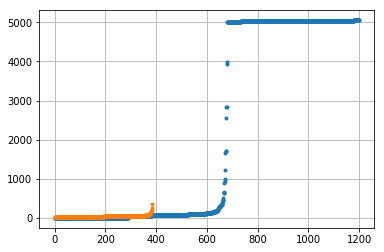

In [22]:
gtimer = GlobalTimer.instance()
import matplotlib.pyplot as plt
plt.plot(sorted(gtimer.timelist_dict["reach"]), '.')
plt.plot(sorted(gtimer.timelist_dict["retrieve"]), '.')
plt.grid(True)

In [25]:
rtime = np.array(gtimer.timelist_dict["reach"])
len(np.where(np.logical_and(rtime<4500, rtime>1000))[0])

10

In [27]:
10.0/1200*100

0.8333333333333334

###  timeout 1초의 문제
* 전체 대비 약 1%, 성공 대비 약 2.5%  오류가 섞임, 
* 5초로 늘리자 1000 샘플 5880초 에서 100 샘플 2700초 수준으로 느려짐, 6000 샘플에는 162,000 초,45 시간 소요 예상
* 무시가능한 수준의 오류이므로 무시

## load data

In [4]:
features_dat_dict_train = defaultdict(list)
retrieve_list_dict_train = defaultdict(list)
feature_time_list_train = []
filter_results_dict_train = defaultdict(lambda:defaultdict(list))
filter_time_dict_train = defaultdict(list)
for folder in sorted(os.listdir(ROBOT_DATA_ROOT)):
    DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, folder)
    try: train_dat = load_pickle(os.path.join(DATASET_PATH, "train_dat.pkl"))
    except: continue
    for k, v in train_dat["features_dat_dict"].items():
        features_dat_dict_train[k] += v
    for k, v in train_dat["retrieve_list_dict"].items():
        retrieve_list_dict_train[k] += v
    feature_time_list_train += train_dat["feature_time_list"]
    for k, v in train_dat["filter_results_dict"].items():
        for vk, vv in v.items():
            filter_results_dict_train[k][vk] += vv
    for k, v in train_dat["filter_time_dict"].items():
        filter_time_dict_train[k] += v

In [5]:
features_dat_dict_test = defaultdict(list)
retrieve_list_dict_test = defaultdict(list)
feature_time_list_test = []
filter_results_dict_test = defaultdict(lambda:defaultdict(list))
filter_time_dict_test = defaultdict(list)
for folder in sorted(os.listdir(ROBOT_DATA_ROOT)):
    DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, folder)
    try: test_dat = load_pickle(os.path.join(DATASET_PATH, "test_dat.pkl"))
    except: continue
    for k, v in test_dat["features_dat_dict"].items():
        features_dat_dict_test[k] += v
    for k, v in test_dat["retrieve_list_dict"].items():
        retrieve_list_dict_test[k] += v
    feature_time_list_test += test_dat["feature_time_list"]
    for k, v in test_dat["filter_results_dict"].items():
        for vk, vv in v.items():
            filter_results_dict_test[k][vk] += vv
    for k, v in test_dat["filter_time_dict"].items():
        filter_time_dict_test[k] += v

## train model

In [19]:
from sklearn import svm
gtimer = GlobalTimer.instance()

In [22]:
train_acc_list = []
test_acc_list = []
C_svm_list = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
clf_dict_list = []

for C_svm in C_svm_list:
    train_res_all = []
    success_list_all = []
    clf_dict = {}
    fail_bds = []
    for rotbd in sorted(retrieve_list_dict_train.keys()):
        feature_mat_train = np.array(features_dat_dict_train[rotbd])
        feature_mat_train[:,:6] = np.abs(feature_mat_train[:,:6])
        label_array = np.array(retrieve_list_dict_train[rotbd])
        clf_dict[rotbd] = svm.SVC(kernel='rbf', C=C_svm, gamma='scale')
        if np.all(label_array) or not np.any(label_array):
            print("no good data - {}".format(rotbd))
            fail_bds.append(rotbd)
            continue
        clf_dict[rotbd].fit(feature_mat_train, label_array)
        train_res_all = train_res_all + list(np.equal(clf_dict[rotbd].predict(feature_mat_train), label_array))
        success_list_all = success_list_all + list(label_array)
    train_res_all = np.array(train_res_all)

    test_res_all = []
    success_list_all_test = []
    test_time_all = []
    for rotbd in sorted(retrieve_list_dict_train.keys()):
        if rotbd in fail_bds:
            continue
        feature_mat_test = np.array(features_dat_dict_test[rotbd])
        feature_mat_test[:,:6] = np.abs(feature_mat_test[:,:6])
        label_array_test = np.array(retrieve_list_dict_test[rotbd])
        for features, label in zip(feature_mat_test, label_array_test):
            clf = clf_dict[rotbd]
            gtimer.tic("predict")
            res = clf.predict(np.array([features]))
            test_time_all.append(gtimer.toc("predict"))
            test_res_all.append(np.equal(res[0], label))
        success_list_all_test = success_list_all_test + list(label_array_test)
    test_res_all = np.array(test_res_all)


    print("=" * 35 + " C={} ".format(C_svm) + "=" * 35)
    print("trainning accuracy ({}) = {} %".format(len(train_res_all), round(np.mean(train_res_all) * 100, 2)))
    print("trainning success accuracy ({}) = {} %".format(int(np.sum(success_list_all)), 
        round(np.mean(train_res_all[np.where(success_list_all)]) * 100, 2)))
    print("trainning failure accuracy ({}) = {} %".format(int(np.sum(np.logical_not(success_list_all))), 
        round(np.mean(train_res_all[np.where(np.logical_not(success_list_all))]) * 100, 2)))
    print("=" * 80)
    print("test accuracy ({}) = {} %".format(len(test_res_all), round(np.mean(test_res_all) * 100, 2)))
    print("test success accuracy ({}) = {} %".format(int(np.sum(success_list_all_test)), 
        round(np.mean(test_res_all[np.where(success_list_all_test)]) * 100, 2)))
    print("test failure accuracy ({}) = {} %".format(int(np.sum(np.logical_not(success_list_all_test))), 
        round(np.mean(test_res_all[np.where(np.logical_not(success_list_all_test))]) * 100, 2)))
    print("-" * 80)
    print("feature time = {} ({}/{})ms".format(round(np.mean(feature_time_list_test), 3), 
                                          round(np.min(feature_time_list_test), 3), round(np.max(feature_time_list_test), 3)))
    print("inference time = {} ({}/{})ms".format(round(np.mean(test_time_all), 3), 
                                          round(np.min(test_time_all), 3), round(np.max(test_time_all), 3)))
    print("=" * 80)
    
    train_acc_list.append(round(np.mean(train_res_all) * 100, 2))
    test_acc_list.append(round(np.mean(test_res_all) * 100, 2))
    clf_dict_list.append(clf_dict)

=================================== C=8 ===================================
trainning accuracy (60000) = 88.42 %
trainning success accuracy (21244) = 82.23 %
trainning failure accuracy (38756) = 91.81 %
test accuracy (12000) = 87.17 %
test success accuracy (4394) = 81.88 %
test failure accuracy (7606) = 90.22 %
--------------------------------------------------------------------------------
feature time = 0.176 (0.054/1.306)ms
inference time = 0.092 (0.055/0.24)ms
=================================== C=16 ===================================
trainning accuracy (60000) = 89.31 %
trainning success accuracy (21244) = 83.68 %
trainning failure accuracy (38756) = 92.39 %
test accuracy (12000) = 87.67 %
test success accuracy (4394) = 82.29 %
test failure accuracy (7606) = 90.78 %
--------------------------------------------------------------------------------
feature time = 0.176 (0.054/1.306)ms
inference time = 0.086 (0.054/0.292)ms
=================================== C=32 ===================

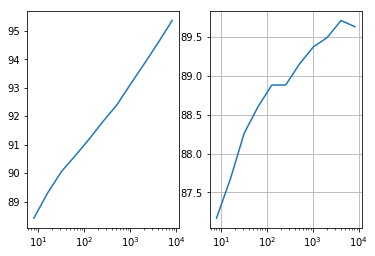

In [23]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(C_svm_list, train_acc_list)
plt.xscale('log')
plt.subplot(1,2,2)
plt.plot(C_svm_list, test_acc_list)
plt.xscale('log')
plt.grid()

#### log - panda
* 1000 x 12 max test accuracy / C_svm: 81.4 / 32
* 2000 x 12 max test accuracy / C_svm: 83.4 / 256
* 3000 x 12 max test accuracy / C_svm: 84.5 / 512
* 3000 x 12 max test accuracy / C_svm: 84.9 / 1024 + scale gamma below
* 4000 x 12 max test accuracy / C_svm: 85.0 / 1024
* **5000 x 12 max test accuracy / C_svm: 85.7 / 1024**
* 6000 x 12 max test accuracy / C_svm: 85.9 / 4096

#### log - indy
*  **5000 x 12 max test accuracy / C_svm: 89.7 / 4096**

# Save model

In [24]:
imax = np.argmax(test_acc_list)
C_svm = C_svm_list[imax]
clf_dict = clf_dict_list[imax]

save_pickle(os.path.join(GF_MODEL_PATH, "{}.pkl".format(ROBOT_TYPE.name)), 
            {"clf_dict": clf_dict,
             "tool_link": TOOL_LINK, 
             "tool_T": T_xyzrpy((TOOL_XYZ, TOOL_RPY))
             }
           )

# Load and test

In [6]:
model = load_pickle(os.path.join(GF_MODEL_PATH, "{}.pkl".format(ROBOT_TYPE.name)))
clf_dict = model["clf_dict"]
gtimer = GlobalTimer.instance()
test_res_all = []
success_list_all_test = []
test_time_all = []
for rotbd in sorted(retrieve_list_dict_train.keys()):
    feature_mat_test = np.array(features_dat_dict_test[rotbd])
    feature_mat_test[:,:6] = np.abs(feature_mat_test[:,:6])
    label_array_test = np.array(retrieve_list_dict_test[rotbd])
    for features, label in zip(feature_mat_test, label_array_test):
        clf = clf_dict[rotbd]
        gtimer.tic("predict")
        res = clf.predict(np.array([features]))
        test_time_all.append(gtimer.toc("predict"))
        test_res_all.append(res[0])
    success_list_all_test = success_list_all_test + list(label_array_test)
test_res_all = np.array(test_res_all)

print("=" * 80)
print_confusion_mat(GT=success_list_all_test, Res=test_res_all)
print("-" * 80)
print("feature time = {} ({}/{})ms".format(round(np.mean(feature_time_list_test), 3), 
                                      round(np.min(feature_time_list_test), 3), round(np.max(feature_time_list_test), 3)))
print("inference time = {} ({}/{})ms".format(round(np.mean(test_time_all), 3), 
                                      round(np.min(test_time_all), 3), round(np.max(test_time_all), 3)))
print("=" * 80)

	 PP 	 	 PN 	 	 12000
GP 	 2849 	 	 885 	 	 76.30%
GN 	 826 	 	 7440 	 90.01%
AL 	 77.52% 	 89.37% 	 85.74%
--------------------------------------------------------------------------------
feature time = 0.134 (0.05/1.279)ms
inference time = 0.076 (0.041/0.241)ms


## Indy
```
================================================================================
	 PP 	 	 PN 	 	 12000
GP 	 3785 	 	 609 	 	 86.14%
GN 	 626 	 	 6980 	 91.77%
AL 	 85.81% 	 91.98% 	 89.71%
--------------------------------------------------------------------------------
feature time = 0.176 (0.054/1.306)ms
inference time = 0.064 (0.041/0.481)ms
================================================================================
```

## Panda
```
================================================================================
	 PP 	 	 PN 	 	 12000
GP 	 2849 	 	 885 	 	 76.30%
GN 	 826 	 	 7440 	 90.01%
AL 	 77.52% 	 89.37% 	 85.74%
--------------------------------------------------------------------------------
feature time = 0.134 (0.05/1.279)ms
inference time = 0.076 (0.041/0.241)ms
================================================================================
```

## test filter results

In [ ]:
fname_accumm = []
for checker in checkers:
    fname_cur = checker.__class__.__name__
    fname_accumm.append(fname_cur)
    test_res_all = []
    success_list_all_test = []
    for rotbd in sorted(retrieve_list_dict_train.keys()):
        filter_results = np.all([filter_results_dict_test[fname][rotbd] for fname in fname_accumm], axis=0)
        label_array_test = np.array(retrieve_list_dict_test[rotbd])
        test_res_all = test_res_all + list(np.equal(filter_results, label_array_test))
        success_list_all_test = success_list_all_test + list(label_array_test)
    test_res_all = np.array(test_res_all)
    filter_times = np.sum([filter_time_dict_test[fname] for fname in fname_accumm], axis=0)
    print("=" * 80)
    print("{} accuracy = {} %".format(fname_cur, round(np.mean(test_res_all) * 100, 2)))
    print("{} success accuracy = {} %".format(fname_cur,
        round(np.mean(test_res_all[np.where(success_list_all_test)]) * 100, 2)))
    print("{} failure accuracy = {} %".format(fname_cur,
        round(np.mean(test_res_all[np.where(np.logical_not(success_list_all_test))]) * 100, 2)))
    print("-" * 80)
    print("{} time = {} ({}/{})ms".format(fname_cur, round(np.mean(filter_times), 3), 
                                          round(np.min(filter_times), 3), round(np.max(filter_times), 3)))
    print("=" * 80)

# visualize grasp directions

In [ ]:
T_dict = load_pickle("data/T_dict.pkl")

In [ ]:
for k in T_dict.keys():
    T_dict[k] = np.array(T_dict[k])

In [ ]:
klist = sorted(T_dict.keys())
for k in klist:
    Tlist = T_dict[k]
    print(k, np.mean(Tlist))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
for ik, k in enumerate(klist):
    plt.subplot(2,6,ik+1)
    plt.plot(T_dict[k][:,:3,0],'.')
    plt.legend("xyz")

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
for ik, k in enumerate(klist):
    plt.subplot(2,6,ik+1)
    plt.plot(T_dict[k][:,:3,1],'.')
    plt.legend("xyz")

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
for ik, k in enumerate(klist):
    plt.subplot(2,6,ik+1)
    plt.plot(T_dict[k][:,:3,2],'.')
    plt.legend("xyz")

In [ ]:
key2dir = {}

In [ ]:
gscene.clear_highlight()

In [ ]:
ik = 0

k = klist[ik+0]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3])
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

k = klist[ik+1]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3], dims=(0.20, 0.005, 0.005))        
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

In [ ]:
gscene.clear_highlight()

In [ ]:
ik = 2

k = klist[ik+0]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3])
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

k = klist[ik+1]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3], dims=(0.20, 0.005, 0.005))        
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

In [ ]:
gscene.clear_highlight()

In [ ]:
ik = 4

k = klist[ik+0]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3])
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

k = klist[ik+1]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3], dims=(0.20, 0.005, 0.005))        
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

In [ ]:
gscene.clear_highlight()

In [ ]:
ik = 6

k = klist[ik+0]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3])
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

k = klist[ik+1]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3], dims=(0.20, 0.005, 0.005))        
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

In [ ]:
gscene.clear_highlight()

In [ ]:
ik = 8

k = klist[ik+0]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3])
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

k = klist[ik+1]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3], dims=(0.20, 0.005, 0.005))        
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

In [ ]:
gscene.clear_highlight()

In [ ]:
ik = 10

k = klist[ik+0]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3])
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

k = klist[ik+1]
print(k)
for ig, T in enumerate(T_dict[k]):
    gscene.add_highlight_axis("ax", "{}_{}_{}".format(k[0], k[1], ig),
                              "base_link",  center=T[:3,3], orientation_mat=T[:3,:3], dims=(0.20, 0.005, 0.005))        
meanY, meanZ = np.mean(T_dict[k][:, :3,1], axis=0), np.mean(T_dict[k][:, :3,2], axis=0)
idxY, idxZ = np.argmax(np.abs(meanY)), np.argmax(np.abs(meanZ))
sgnY, sgnZ = np.sign(meanY[idxY]), np.sign(meanZ[idxZ])

dirY, dirZ = np.zeros(3,dtype=np.int), np.zeros(3,dtype=np.int)
dirY[idxY], dirZ[idxZ] = sgnY, sgnZ
key2dir[k] = (dirY, dirZ)
print(key2dir[k])

In [ ]:
gscene.clear_highlight()

In [ ]:
print("key2dir = {")
for k in sorted(key2dir.keys()):
    print("\t {} : ({}, {}),".format(k, tuple(key2dir[k][0]), tuple(key2dir[k][1])))
print("}")

for k in klist:
    checkY, checkZ = all(np.matmul(T_dict[k][:, :3,1], key2dir[k][0])>0), all(np.matmul(T_dict[k][:, :3,2], key2dir[k][1])>0)
    print("{} \t - {} / {}".format(k, checkY, checkZ))
    gscene.clear_highlight()
    assert checkY and checkZ, "wrong assignment"

In [ ]:
key2dir = {
	 (False, 'hdl_bk_a') : ((0, -1, 0), (1, 0, 0)),
	 (False, 'hdl_bk_b') : ((0, -1, 0), (-1, 0, 0)),
	 (False, 'hdl_ft_a') : ((0, 1, 0), (1, 0, 0)),
	 (False, 'hdl_ft_b') : ((0, 1, 0), (-1, 0, 0)),
	 (False, 'hdl_tp_a') : ((0, 0, 1), (1, 0, 0)),
	 (False, 'hdl_tp_b') : ((0, 0, 1), (-1, 0, 0)),
	 (True, 'hdl_bk_a') : ((1, 0, 0), (0, 1, 0)),
	 (True, 'hdl_bk_b') : ((1, 0, 0), (0, -1, 0)),
	 (True, 'hdl_ft_a') : ((-1, 0, 0), (0, 1, 0)),
	 (True, 'hdl_ft_b') : ((-1, 0, 0), (0, -1, 0)),
	 (True, 'hdl_tp_a') : ((0, 0, 1), (0, 1, 0)),
	 (True, 'hdl_tp_b') : ((0, 0, 1), (0, -1, 0)),
}